In [1]:
!which python

/bin/bash: /home/shiya/anaconda3/envs/music/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/shiya/anaconda3/envs/music/bin/python


In [15]:
import librosa
import librosa.display
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import os 
import random


# import spectrogram
# from spectrogram import generate_spec
# from spectrogram import truncate_spec
# from spectrogram import mask_spec
# from spectrogram import add_noise
# from spectrogram import path_to_preprocessing
from spectrogram_class import spectrogram
from spec_input_generator import gen, gen_eval

In [3]:
spectrogram

spectrogram_class.spectrogram

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-07-11 11:24:53.439431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 11:24:53.447100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 11:24:53.447430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
import librosa

# 1. Get the file path to an included audio example
filename = librosa.example('nutcracker')


# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y, sr = librosa.load(filename)
print(y)

# 3. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)


[ 2.2716861e-06  5.3327208e-06 -7.2473290e-06 ...  1.1170751e-05
  1.2871884e-06  5.4120628e-06]
Estimated tempo: 107.67 beats per minute


In [6]:
hop_length = 4096
win_length = 1024
n_fft = 1024

In [7]:
%%time
test_spec = spectrogram('PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.wav')

/home/shiya/anaconda3/envs/music/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


NOISE HIT
CPU times: user 121 ms, sys: 222 ms, total: 342 ms
Wall time: 648 ms


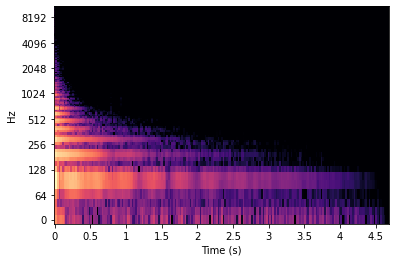

In [8]:
test_spec.plot_spec() 

In [8]:
%%time 
sample_raw, _ =librosa.load('../data/_OrchideaSOL2020_release/OrchideaSOL2020/PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.wav')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 2.15 s, sys: 148 ms, total: 2.3 s
Wall time: 1.82 s


In [9]:
print(scipy.stats.iqr(sample_raw))

0.00021132442270754836


In [10]:
test = np.array([2, 4, 6, 8, 10])
scipy.convolve(test,np.ones(5,dtype='float')/5, 'same')

/tmp/ipykernel_23540/1454046401.py:2: DeprecationWarning: scipy.convolve is deprecated and will be removed in SciPy 2.0.0, use numpy.convolve instead
  scipy.convolve(test,np.ones(5,dtype='float')/5, 'same')


array([2.4, 4. , 6. , 5.6, 4.8])

In [11]:
def rolling_mean(arr, win):
    return scipy.convolve(arr, np.ones(win, dtype = 'float')/win, 'same')

In [12]:
def get_signal_range(arr):
    tmp = rolling_mean(arr, 100) < 0.001
    rolling_tmp = [all(tmp[x:x+500]) for x in range(len(tmp) - 500)]
    # plt.scatter(range(len(rolling_tmp)), rolling_tmp)
    for i in range(len(rolling_tmp)):
        if rolling_tmp[i] == True:
            return i

In [13]:
%%time
print(get_signal_range(sample_raw))

/tmp/ipykernel_23540/4247337007.py:2: DeprecationWarning: scipy.convolve is deprecated and will be removed in SciPy 2.0.0, use numpy.convolve instead
  return scipy.convolve(arr, np.ones(win, dtype = 'float')/win, 'same')


27590
CPU times: user 4.98 s, sys: 0 ns, total: 4.98 s
Wall time: 4.98 s


/tmp/ipykernel_23540/4247337007.py:2: DeprecationWarning: scipy.convolve is deprecated and will be removed in SciPy 2.0.0, use numpy.convolve instead
  return scipy.convolve(arr, np.ones(win, dtype = 'float')/win, 'same')


(0.0, 1000.0)

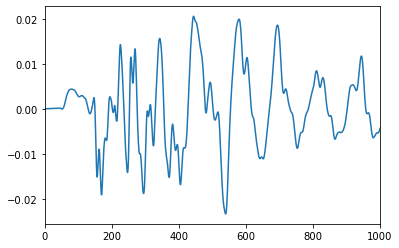

In [14]:
plt.plot(rolling_mean(sample_raw, 100))
plt.xlim(0, 1000)

(0.0, 1000.0)

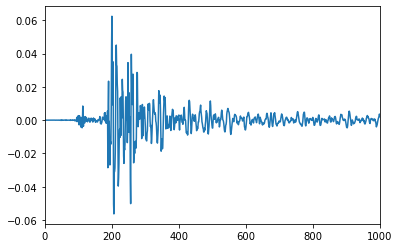

In [15]:
plt.plot(np.diff(sample_raw, 2))
plt.xlim(0, 1000)

In [16]:
print(max(sample_raw))

0.22712395


5.545808e-07


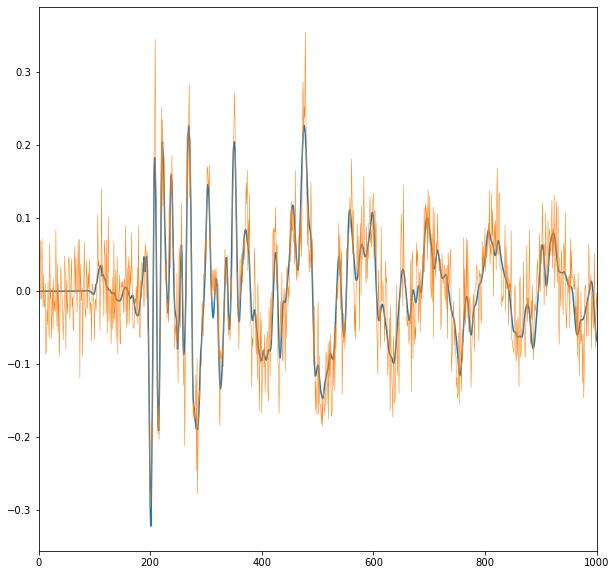

In [17]:
plt.figure(figsize=(10, 10))
plt.plot(range(len(sample_raw)), sample_raw)
print(sample_raw.mean())
plt.xlim((0, 1000))
plt.plot(add_noise(sample_raw), linewidth = 0.5)

In [18]:
type(sample_raw)

numpy.ndarray

In [19]:
%%time
sample = spectrogram.generate_spec(path = 'PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.wav', hop_length = hop_length, 
                win_length = win_length, n_fft = n_fft)

CPU times: user 103 ms, sys: 84.5 ms, total: 188 ms
Wall time: 259 ms


Text(0.5, 1.0, 'Log-frequency power spectrogram')

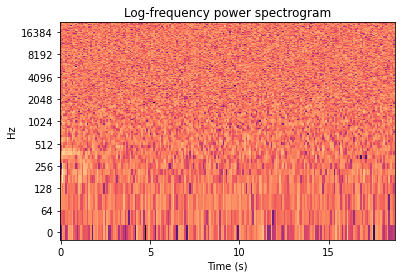

In [20]:
fig = plt.figure()
D = librosa.amplitude_to_db(sample,
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=44100, hop_length=hop_length,
                         x_axis='s')
plt.title('Log-frequency power spectrogram')

In [21]:
sample.shape

(513, 202)

In [22]:
tf.data.Dataset.from_tensor_slices(sample)

2022-07-08 17:10:01.140660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-08 17:10:01.141943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 17:10:01.142660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 17:10:01.143230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<TensorSliceDataset element_spec=TensorSpec(shape=(202,), dtype=tf.float64, name=None)>

In [23]:
librosa.stft(y, n_fft = 512)

array([[-1.1324945e-05+0.0000000e+00j, -5.9295135e-06+0.0000000e+00j,
         2.4049077e-08+0.0000000e+00j, ...,
         8.6508841e-08+0.0000000e+00j, -3.5013736e-06+0.0000000e+00j,
        -1.9958648e-05+0.0000000e+00j],
       [ 1.1368136e-05-5.5574304e-07j,  2.5191318e-07+5.9616295e-06j,
        -9.0220249e-09+2.1532888e-10j, ...,
         3.6815095e-08-6.4224650e-08j, -2.3503426e-06-2.6892465e-06j,
         1.4495911e-05-1.3619434e-05j],
       [-1.1421112e-05+1.1178735e-06j,  5.9823728e-06-5.1026706e-07j,
         2.0904285e-08+8.8823828e-09j, ...,
         5.8875238e-09-1.9933788e-08j,  3.9882735e-07-3.7238171e-06j,
        -1.5052420e-06+1.9833931e-05j],
       ...,
       [-8.2442915e-05-1.8629836e-06j,  5.6095636e-05-8.4990068e-05j,
         4.9876959e-05+1.7319288e-05j, ...,
         1.4589037e-06-3.9880051e-05j, -1.9478661e-05-2.9171460e-05j,
        -2.6922930e-06+1.7060946e-05j],
       [ 3.7757571e-05-2.1668193e-05j, -1.1536949e-05-2.9872772e-06j,
         1.6668135e-05

In [24]:
meta_df = pd.read_csv('../data/OrchideaSOL_metadata.csv')
meta_df.head()

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0
2,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34.0,f,3.0,0.0,S,Sordina,NaN,True,1
3,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34.0,p,1.0,0.0,S,Sordina,NaN,True,2
4,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#2,46.0,f,3.0,0.0,S,Sordina,NaN,True,1


In [25]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13265 entries, 0 to 13264
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Path                         13265 non-null  object 
 1   Family (abbr.)               13265 non-null  object 
 2   Family (in full)             13265 non-null  object 
 3   Instrument (abbr.)           13265 non-null  object 
 4   Instrument (in full)         13265 non-null  object 
 5   Technique (abbr.)            13265 non-null  object 
 6   Technique (in full)          13265 non-null  object 
 7   Pitch                        13265 non-null  object 
 8   Pitch ID (if applicable)     13162 non-null  float64
 9   Dynamics                     13265 non-null  object 
 10  Dynamics ID (if applicable)  12646 non-null  float64
 11  Instance ID                  13262 non-null  float64
 12  Mute (abbr.)                 13265 non-null  object 
 13  Mute (in full)  

In [26]:
meta_df.describe()

,Pitch ID (if applicable),Dynamics ID (if applicable),Instance ID,String ID (if applicable),Fold
count,13162.000000,12646.000000,13262.000000,7516.000000,13265.000000
mean,63.842653,2.073857,0.848138,2.360298,2.000000
std,16.512067,1.329919,1.177874,1.196041,1.414267
min,20.000000,0.000000,0.000000,1.000000,0.000000
25%,52.000000,2.000000,0.000000,1.000000,1.000000
50%,64.000000,2.000000,0.000000,2.000000,2.000000
75%,76.000000,3.000000,2.000000,3.000000,3.000000
max,109.000000,4.000000,12.000000,6.000000,4.000000


In [27]:
meta_df.isnull().sum()

Path                              0
Family (abbr.)                    0
Family (in full)                  0
Instrument (abbr.)                0
Instrument (in full)              0
Technique (abbr.)                 0
Technique (in full)               0
Pitch                             0
Pitch ID (if applicable)        103
Dynamics                          0
Dynamics ID (if applicable)     619
Instance ID                       3
Mute (abbr.)                      0
Mute (in full)                    0
String ID (if applicable)      5749
Needed digital retuning           0
Fold                              0
dtype: int64

In [28]:
meta_df['Instrument (in full)'].value_counts()

Violin            1987
Viola             1952
Contrabass        1636
Cello             1593
Accordion          872
Trombone           670
Trumpet in C       590
French Horn        589
Flute              529
Harp               507
Bass Tuba          500
Clarinet in Bb     406
Alto Saxophone     377
Bassoon            358
Guitar             353
Oboe               346
Name: Instrument (in full), dtype: int64

In [29]:
len(meta_df['Instrument (in full)'].unique())

16

We don'really care about the pitchID, Dynamics Id and String ID.

<AxesSubplot:>

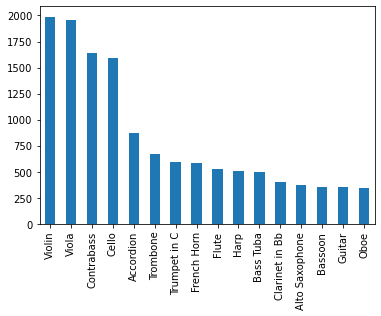

In [30]:
meta_df['Instrument (in full)'].value_counts().plot(kind='bar')

We can see some degree of bias in the instrument classes.

## First baseline model is to predict the instrument present in the audio file.


In [31]:
train_df, test_df = train_test_split(meta_df, train_size = 0.7, random_state = 42)

In [32]:
print('The number of rows for the training data is ', train_df.shape[0])
print('The number of rows for the test data is ', test_df.shape[0])

The number of rows for the training data is  9285
The number of rows for the test data is  3980


In [33]:
spec_shape = sample.shape
spec_shape

(513, 202)

In [34]:
meta_df

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0
2,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34.0,f,3.0,0.0,S,Sordina,NaN,True,1
3,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34.0,p,1.0,0.0,S,Sordina,NaN,True,2
4,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#2,46.0,f,3.0,0.0,S,Sordina,NaN,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13260,Winds/Sax_Alto/slap_pitched/ASax-slap-G4-f-N-N...,Winds,Woodwinds,ASax,Alto Saxophone,slap,slap_pitched,G4,67.0,f,3.0,0.0,N,None,NaN,False,1
13261,Winds/Sax_Alto/slap_pitched/ASax-slap-G4-mf-N-...,Winds,Woodwinds,ASax,Alto Saxophone,slap,slap_pitched,G4,67.0,mf,2.0,0.0,N,None,NaN,False,4
13262,Winds/Sax_Alto/slap_unpitched/ASax-slap_unp-C#...,Winds,Woodwinds,ASax,Alto Saxophone,slap_unp,slap_unpitched,C#3,49.0,p,1.0,0.0,N,None,NaN,False,2
13263,Winds/Sax_Alto/slap_unpitched/ASax-slap_unp-C#...,Winds,Woodwinds,ASax,Alto Saxophone,slap_unp,slap_unpitched,C#4,61.0,p,1.0,0.0,N,None,NaN,False,0


In [35]:
model = models.Sequential()
model.add(layers.InputLayer((spec_shape[0], spec_shape[1], 1), dtype = tf.float64))
model.add(layers.Conv2D(30, (200, 20), strides=(10, 10), activation='relu'))
# , input_shape = (spec_shape[0], spec_shape[1], 1)))
model.add(layers.MaxPool2D((5, 5)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation = 'sigmoid'))
model.build()

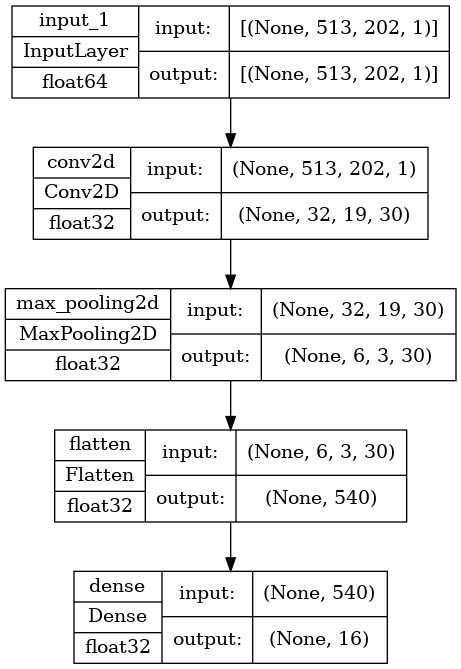

In [36]:
tf.keras.utils.plot_model(model, show_shapes = True, show_dtype= True)

In [37]:
instrument_df = meta_df[['Path', 'Instrument (in full)']]
dummy_df = pd.get_dummies(instrument_df, columns = ['Instrument (in full)'])
train_df, test_df = train_test_split(dummy_df, train_size = 0.75)
train_df.head(2)

,Path,Instrument (in full)_Accordion,Instrument (in full)_Alto Saxophone,Instrument (in full)_Bass Tuba,Instrument (in full)_Bassoon,Instrument (in full)_Cello,Instrument (in full)_Clarinet in Bb,Instrument (in full)_Contrabass,Instrument (in full)_Flute,Instrument (in full)_French Horn,Instrument (in full)_Guitar,Instrument (in full)_Harp,Instrument (in full)_Oboe,Instrument (in full)_Trombone,Instrument (in full)_Trumpet in C,Instrument (in full)_Viola,Instrument (in full)_Violin
5469,Strings/Contrabass/sul_tasto_tremolo/Cb-tasto_...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6072,Strings/Viola/artificial_harmonic/Va-art_harm-...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [38]:
random.random()

0.10332157998634839

In [39]:
rel_path = glob.glob('../data/**[!MACOSC]/*OrchideaSOL2020/', recursive=True)[0]
rel_path

'../data/_OrchideaSOL2020_release/OrchideaSOL2020/'

In [40]:
# def gen(noise_prob = 0.3, mask_prob = 0.3):
#     df = train_df.copy()
#     while True: 
#         tmp_df = df.sample(1)
#         path = tmp_df['Path'].values[0]
#         if random.random() < noise_prob:
#             noise_bool = True
#             print("noise HIT!!")
#         else:
#             noise_bool = False
#         spec = generate_spec(path, hop_length = hop_length, win_length = win_length,
#                                 n_fft = n_fft, noise= noise_bool)
#         plt.plot(librosa.load(rel_path + path, sr = 44100)[0])
#         spec = truncate_spec(spec, spec_shape[1])
#         if random.random() < mask_prob:
#             spec = mask_spec(spec) 
#         spec = np.expand_dims(spec, -1)
#         yield spec, np.reshape(tmp_df[list(set(df.columns) - set(['Path']))].values, (16,))
    
# def gen_eval(noise_prob = 0.3, mask_prob = 0.3):
#     df = test_df.copy()
#     while True:
#         tmp_df = df.sample(1)
#         path = tmp_df['Path'].values[0]
#         if random.random() < noise_prob: 
#             noise_bool = True
#         else:
#             noise_bool = False
#         spec = generate_spec(path, hop_length = hop_length, win_length = win_length, n_fft = n_fft)
#         spec = truncate_spec(spec, spec_shape[1])
#         if random.random() < mask_prob: 
#             spec = mask_spec(spec) 
#         spec = np.expand_dims(spec, -1)
#         yield spec, np.reshape(tmp_df[list(set(df.columns) - set(['Path']))].values, (16,))

In [41]:
def get_eval_df(df):
    tmp = df.copy()
    tmp['spec'] = tmp['Path'].apply(generate_spec)
    tmp.drop(columns=['Path'], inplace = True)
    return tmp

In [42]:
def npy_gen(df):
    while True:
        tmp = df.copy()
        tmp = df['Path'].apply(path_to_preprocessing)
        print(tmp)
        print(tmp.shape)
    
    
    

(513, 202, 1)


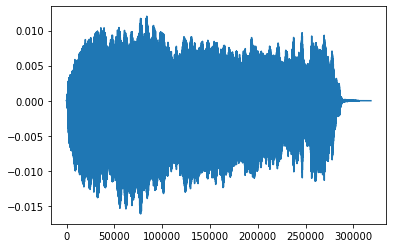

In [ ]:
sample, _ = next(gen())
print(sample.shape)

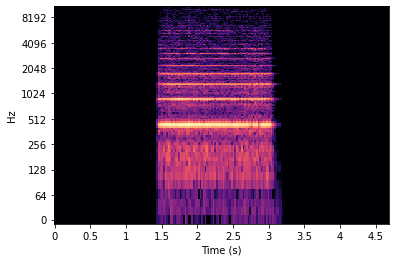

In [ ]:
librosa.display.specshow(librosa.amplitude_to_db(np.reshape(sample, (sample.shape[:2]))), x_axis = 's', y_axis = 'log')

In [ ]:
BATCH_SIZE = 100

train_generator = (tf.data.Dataset.from_generator(lambda x: gen(noise_prob = 0.4), output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)
eval_generator = (tf.data.Dataset.from_generator(gen_eval, output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
print(model.metrics)

: 

: 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 19, 30)        120030    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 3, 30)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 540)               0         
                                                                 
 dense (Dense)               (None, 16)                8656      
                                                                 
Total params: 128,686
Trainable params: 128,686
Non-trainable params: 0
_________________________________________________________________


In [ ]:
len(train_df)//BATCH_SIZE

99

In [49]:
from datetime import datetime
datetime.now().strftime('%Y%m%d_%H%M%S')


'20220706_100948'

In [62]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_model", 
                                                    monitor='val_accuracy')
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 2)


history = model.fit(train_generator, epochs = 6, verbose=1, steps_per_epoch= 10, 
                    validation_data = eval_generator,
                    validation_steps = 10, validation_freq= 2, 
                    use_multiprocessing=True, workers = 2, callbacks=[ckpt_callback, early_callback])

Epoch 1/6
10/10 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.4790 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_01_model/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_01_model/assets


10/10 [==============================] - 526s 53s/step - loss: 0.1695 - accuracy: 0.4790
Epoch 2/6
10/10 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.5050 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_02_model/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_02_model/assets


10/10 [==============================] - 991s 105s/step - loss: 0.1580 - accuracy: 0.5050 - val_loss: 0.1967 - val_accuracy: 0.2300
Epoch 3/6
10/10 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.4910 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_03_model/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_03_model/assets


10/10 [==============================] - 527s 53s/step - loss: 0.1590 - accuracy: 0.4910
Epoch 4/6
 3/10 [========>.....................] - ETA: 6:08 - loss: 0.1579 - accuracy: 0.4833

In [52]:
# model.save('../models/baseline/')

In [53]:
# model = tf.keras.models.load_model('../models/baseline_checkpoint/20220705_135043_02_model/')

In [54]:
# model.save_weights('../models/baseline_checkpoint/20220704_153658_model/')

In [ ]:
model(np.reshape(random_train, (1, 1025, 807, 1)), training= False)

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[0.25098786, 0.28979725, 0.19388774, 0.3408277 , 0.29772896,
        0.41419387, 0.20505759, 0.24066192, 0.49796218, 0.2604622 ,
        0.32297462, 0.41928884, 0.14825433, 0.24044338, 0.35180917,
        0.27159938]], dtype=float32)>

## Deeper model


In [45]:
model_2conv = models.Sequential()
model_2conv.add(layers.InputLayer((spec_shape[0], spec_shape[1], 1), dtype = tf.float64))
model_2conv.add(layers.Conv2D(30, (200, 20), activation='relu'))
# , input_shape = (spec_shape[0], spec_shape[1], 1)))
model_2conv.add(layers.MaxPool2D((5, 5)))
model_2conv.add(layers.Conv2D(20, (20, 5), activation = 'relu'))
model_2conv.add(layers.Flatten())
model_2conv.add(layers.Dense(16, activation = 'sigmoid'))
model_2conv.build()

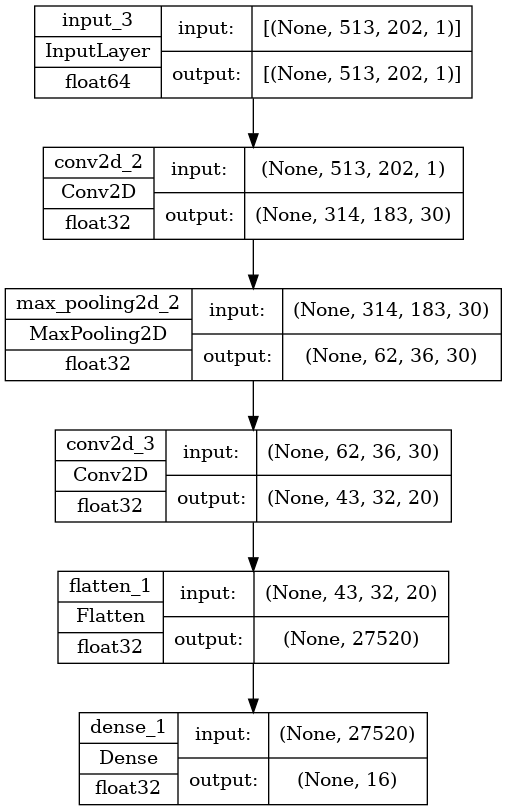

In [46]:
tf.keras.utils.plot_model(model_2conv, show_shapes = True, show_dtype= True)

In [47]:
model_2conv.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 314, 183, 30)      120030    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 36, 30)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 32, 20)        60020     
                                                                 
 flatten_1 (Flatten)         (None, 27520)             0         
                                                                 
 dense_1 (Dense)             (None, 16)                440336    
                                                                 
Total params: 620,386
Trainable params: 620,386
Non-trainable params: 0
________________________________________________

In [11]:
test_npy = np.load('../data/_OrchideaSOL2020_release/OrchideaSOL2020/PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.npy', 
allow_pickle = True)

In [12]:
test_npy.shape

(513, 202)